In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math
from sklearn.linear_model import LinearRegression
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
import seaborn as sns

In [34]:
# Constant
VALIDATION_PORTION = 0.2
FEATURES = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']
TARGET = ['NMHC(GT)', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Data Preparation

In [3]:
from ucimlrepo import fetch_ucirepo 

In [4]:
air_quality = fetch_ucirepo(id=360)
origin = air_quality.data.features

In [5]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [6]:
# process data
origin.replace(-200, np.nan, inplace=True)
origin['Datetime'] = origin['Date'] + ' ' + origin['Time']
origin.drop(columns=['Date', 'Time'], inplace=True)
origin['Datetime'] = pd.to_datetime(origin['Datetime'])

In [7]:
origin.set_index('Datetime', inplace=True)
origin = origin.sort_index(axis=1)
origin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AH             8991 non-null   float64
 1   C6H6(GT)       8991 non-null   float64
 2   CO(GT)         7674 non-null   float64
 3   NMHC(GT)       914 non-null    float64
 4   NO2(GT)        7715 non-null   float64
 5   NOx(GT)        7718 non-null   float64
 6   PT08.S1(CO)    8991 non-null   float64
 7   PT08.S2(NMHC)  8991 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   PT08.S4(NO2)   8991 non-null   float64
 10  PT08.S5(O3)    8991 non-null   float64
 11  RH             8991 non-null   float64
 12  T              8991 non-null   float64
dtypes: float64(13)
memory usage: 1023.4 KB


In [8]:
origin=origin[['NMHC(GT)', 'CO(GT)', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)',
               'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
               'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]

In [9]:
train_dataset = origin[:'2004-12-31 23:00:00']
test_dataset = origin['2005-01-01 00:00:00':]

In [10]:
X_train = train_dataset[FEATURES]
Y_train = train_dataset[TARGET]

# missing value handling

In [11]:
def plot_missing_values_heatmap(dataset):
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(dataset.isna(), cbar=False)
# 获取索引
    dates = dataset.index

# 每1024条数据显示一个标签（假设你的数据是每小时一次）
    ax.set_yticks(range(0, len(dates), 1024))
    ax.set_yticklabels([d.strftime('%y-%m-%d') for d in dates[::1024]], fontsize=7)
    plt.title("Missing Values Heatmap (-200 replaced by NaN)")
    plt.show()

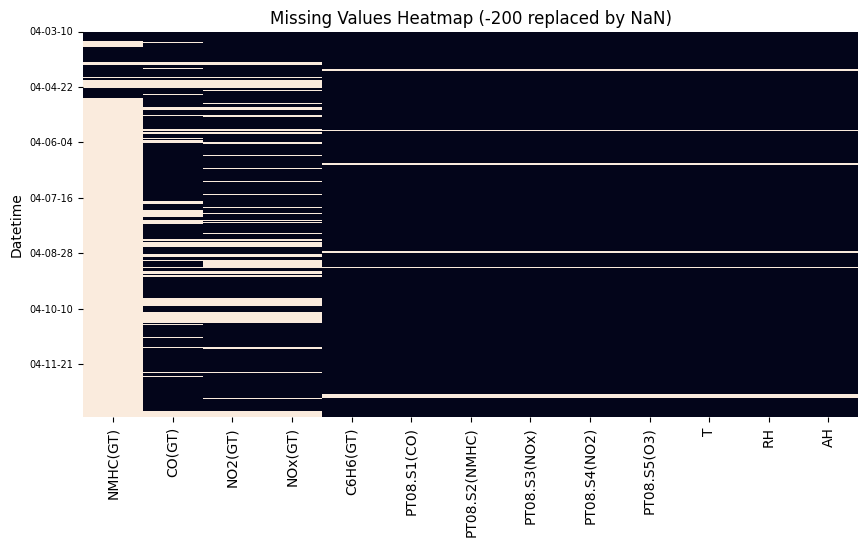

In [12]:
plot_missing_values_heatmap(train_dataset)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    6882 non-null   float64
 1   PT08.S2(NMHC)  6882 non-null   float64
 2   PT08.S3(NOx)   6882 non-null   float64
 3   PT08.S4(NO2)   6882 non-null   float64
 4   PT08.S5(O3)    6882 non-null   float64
 5   T              6882 non-null   float64
 6   RH             6882 non-null   float64
 7   AH             6882 non-null   float64
dtypes: float64(8)
memory usage: 499.9 KB


In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled_df = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

In [20]:
def plot_scatter_each_column_rolling(dataset, window=1):
    for col in dataset.columns:
        plt.figure(figsize=(10, 4))

    # 计算滑动平均
        rolling_values = dataset[col].rolling(window=window, min_periods=1).mean()
        plt.scatter(dataset.index, rolling_values, s=5)
        plt.title(f"Rolling Mean Scatter Plot ({window}) for {col}")
        plt.xlabel("Datetime")
        plt.ylabel(f"{col} (Rolling Mean)")
        plt.tight_layout()
        plt.show()

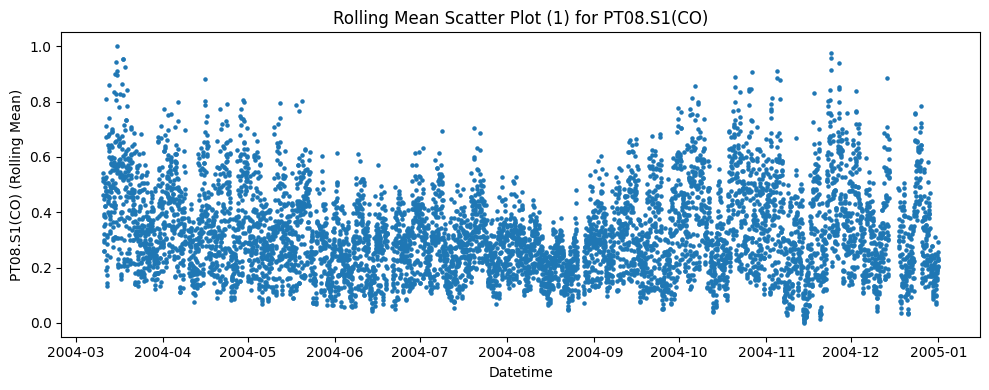

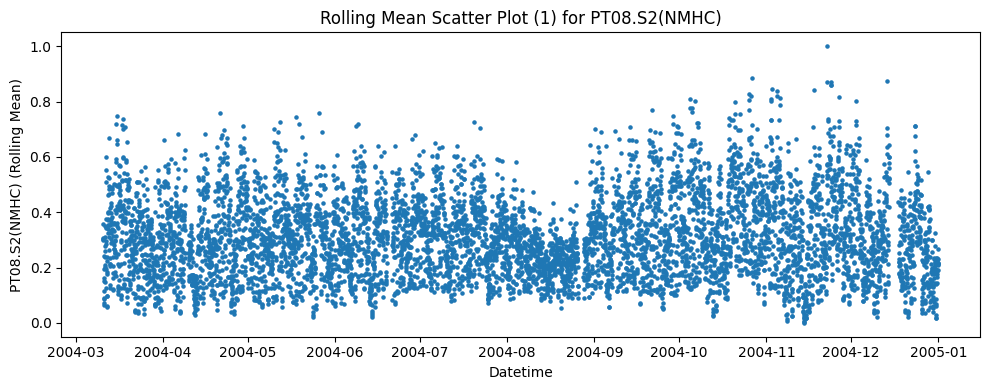

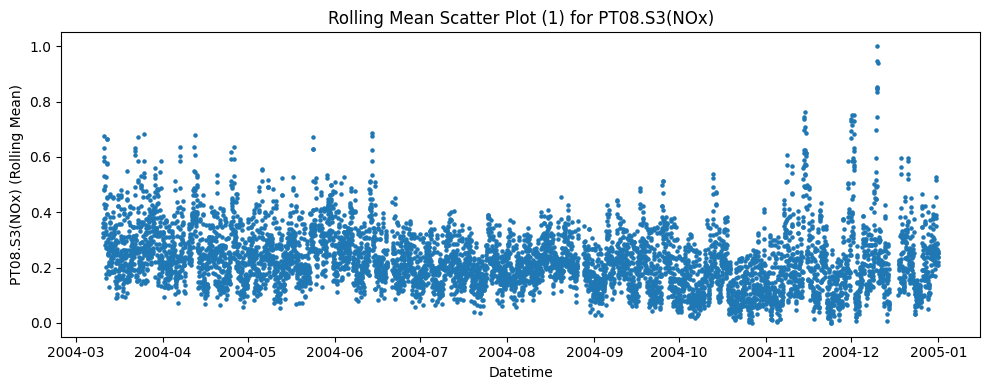

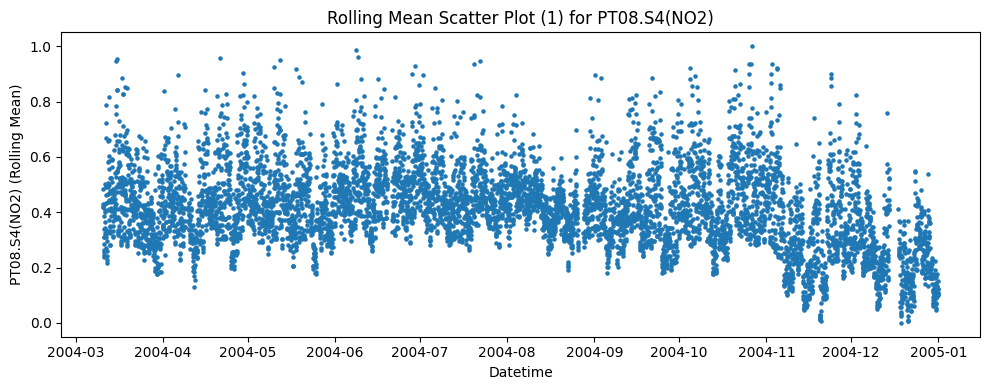

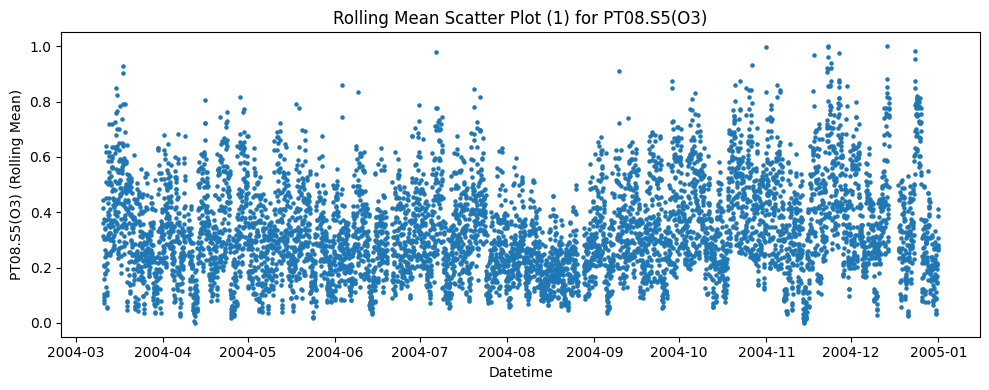

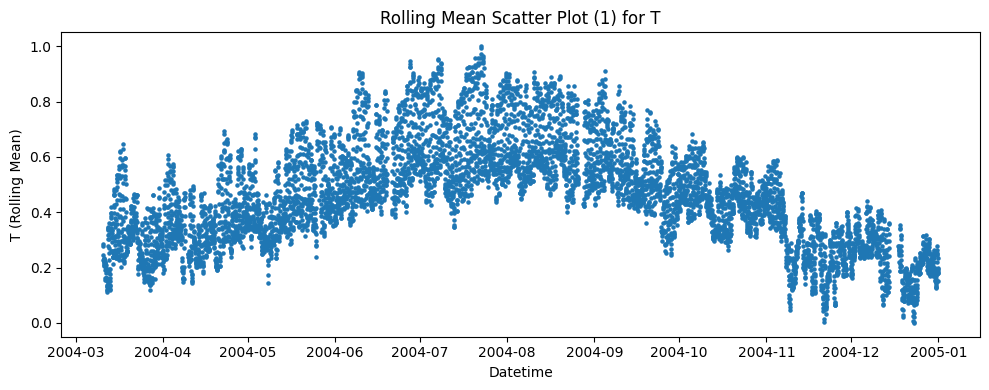

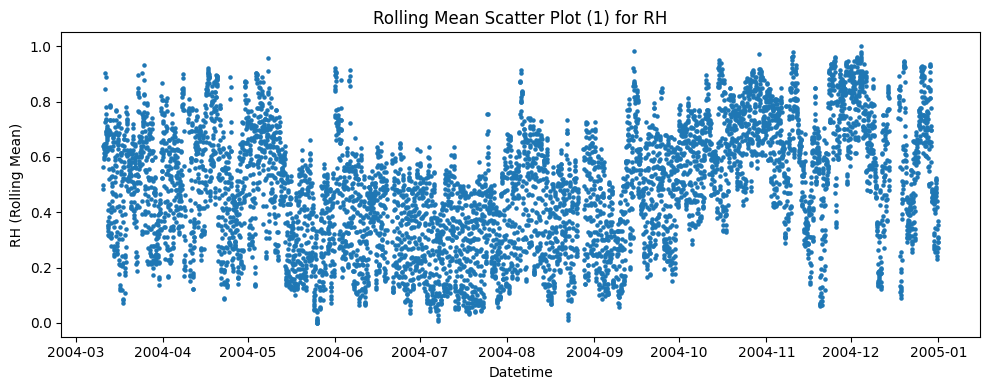

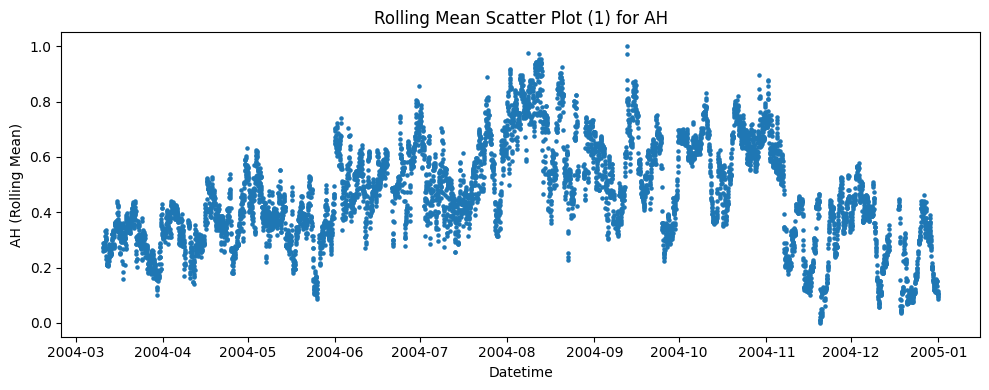

In [21]:
plot_scatter_each_column_rolling(X_train_scaled_df, window=1)

In [23]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_scaled_df), columns=X_train_scaled_df.columns, index=X_train_scaled_df.index)
X_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 2004-03-10 18:00:00 to 2004-12-31 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    7110 non-null   float64
 1   PT08.S2(NMHC)  7110 non-null   float64
 2   PT08.S3(NOx)   7110 non-null   float64
 3   PT08.S4(NO2)   7110 non-null   float64
 4   PT08.S5(O3)    7110 non-null   float64
 5   T              7110 non-null   float64
 6   RH             7110 non-null   float64
 7   AH             7110 non-null   float64
dtypes: float64(8)
memory usage: 499.9 KB


In [24]:
def plot_scatter_each_column_highlight_missing(dataset, imputed_dataset):
    for col in dataset.columns:
        # 原始的 NaN mask（True = 原来是缺失）
        nan_mask = dataset[col].isna()

        plt.figure(figsize=(12,5))

        # 蓝色点：原本非缺失位置
        plt.scatter(dataset.index[~nan_mask],
                    imputed_dataset[col][~nan_mask],
                    s=12, label='Original values', alpha=0.7)

        # 红色点：原本是缺失 → 用填充值显示
        plt.scatter(dataset.index[nan_mask],
                    imputed_dataset[col][nan_mask],
                    s=12, color='red', label='Imputed values')

        plt.title(f"Imputed values highlighted in red: {col}")
        plt.legend()
        plt.show()

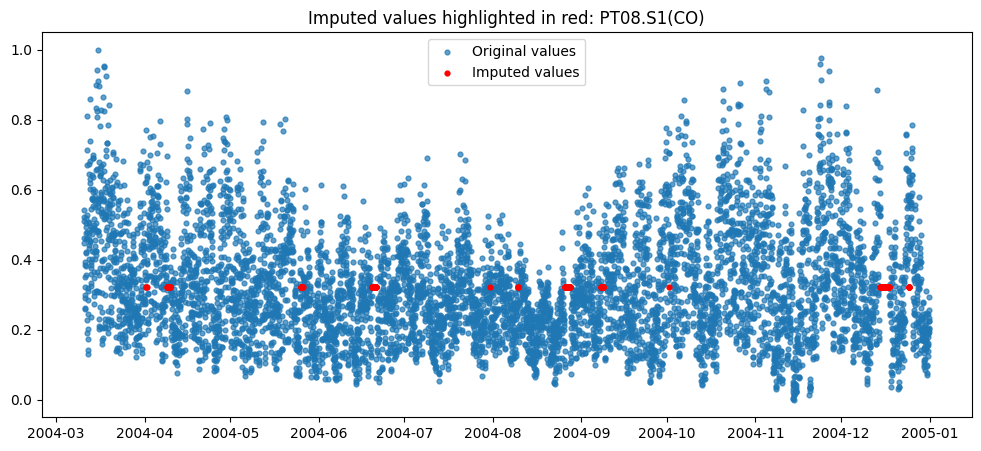

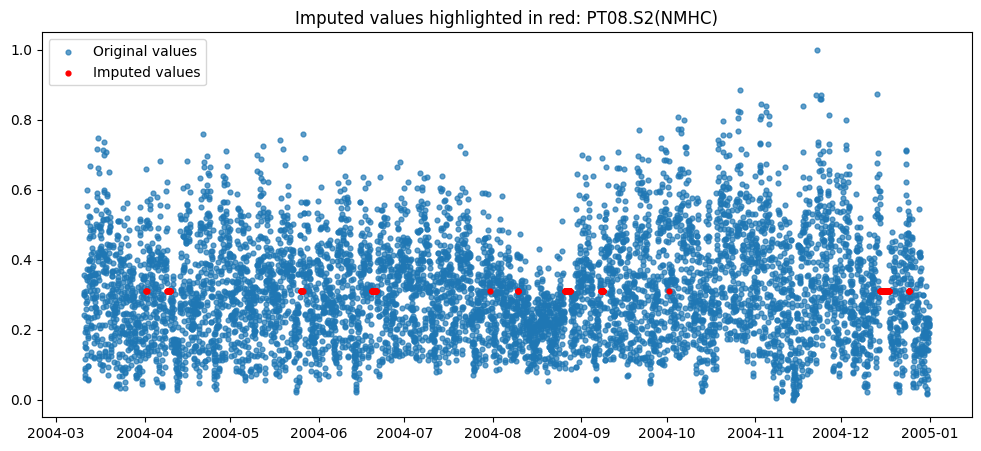

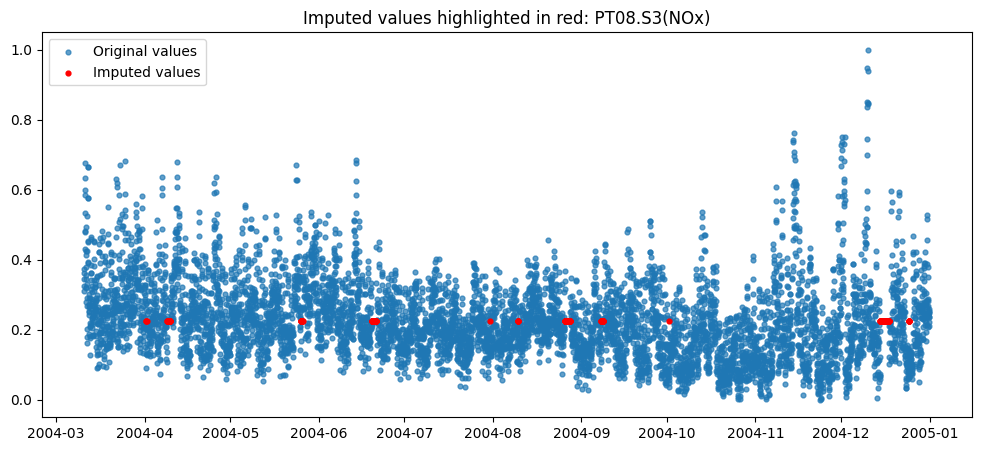

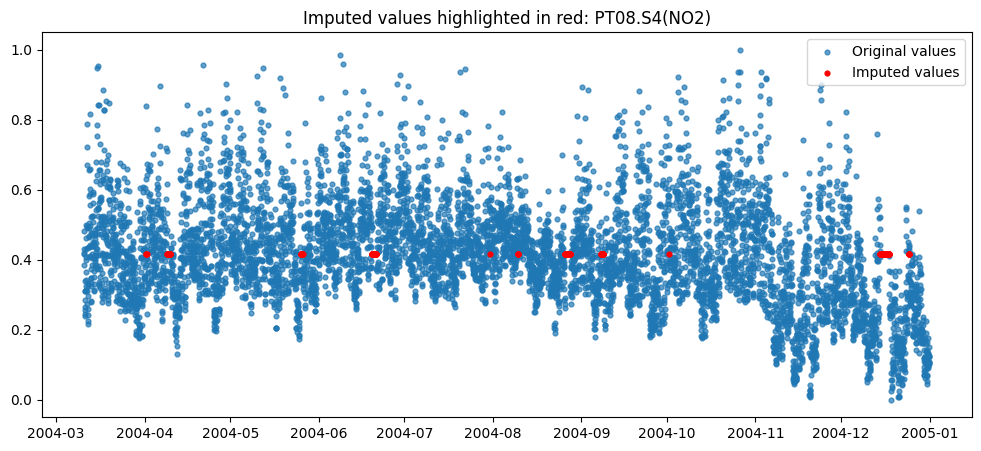

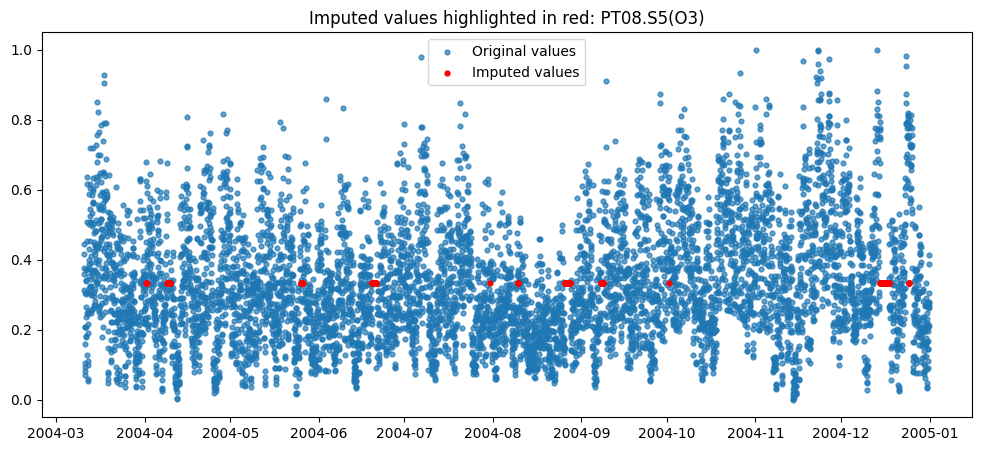

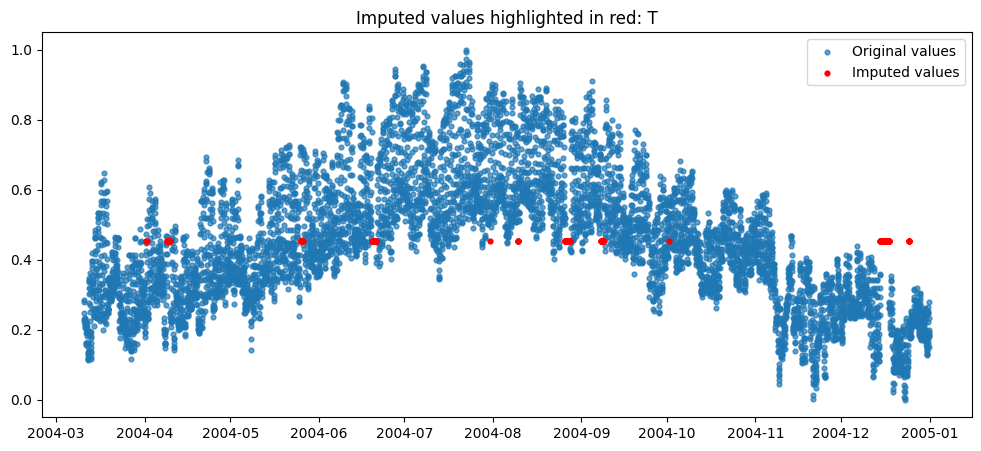

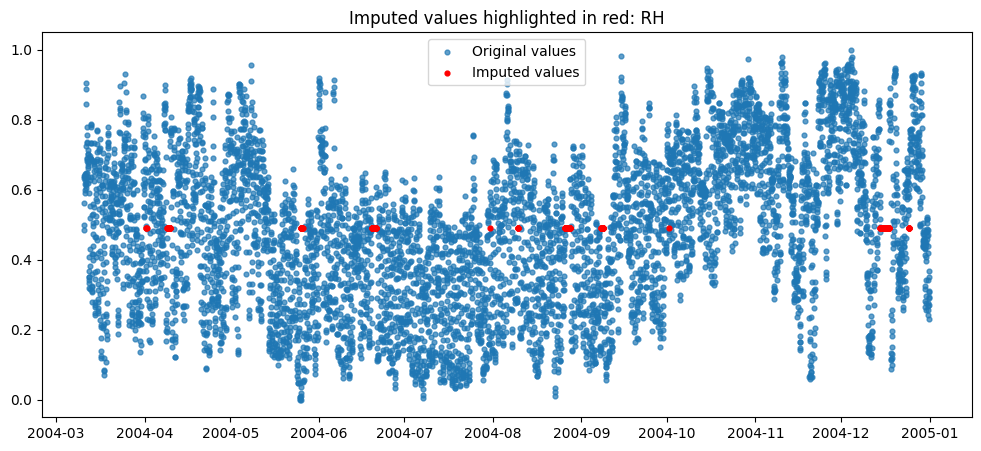

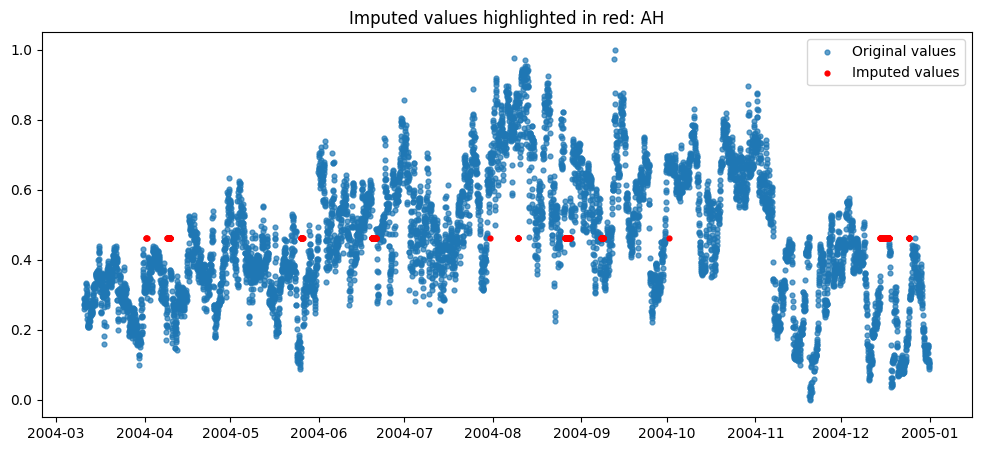

In [25]:
plot_scatter_each_column_highlight_missing(X_train_scaled_df, X_train_imputed)

In [32]:
def create_lagged_features(dataset:pd.DataFrame,lags: list) -> pd.DataFrame:
    lagged_data = pd.DataFrame(index=dataset.index)
    for col in dataset.columns:
        for lag in lags:
            lagged_col_name = f"{col}_lag{lag}"
            lagged_data[lagged_col_name] = dataset[col].shift(lag)
    return lagged_data

def create_rolling_features(dataset:pd.DataFrame, window_sizes: list) -> pd.DataFrame:
    rolling_data = pd.DataFrame(index=dataset.index)
    for col in dataset.columns:
        for window in window_sizes:
            rolling_col_name = f"{col}_roll{window}"
            rolling_data[rolling_col_name] = dataset[col].rolling(window=window, min_periods=1).mean()
    return rolling_data

In [36]:
def create_features(dataset:pd.DataFrame, lags: list, window_sizes: list) -> pd.DataFrame:
    lagged_features = create_lagged_features(dataset, lags)
    rolling_features = create_rolling_features(dataset, window_sizes)
    combined_features = pd.concat([dataset, lagged_features, rolling_features], axis=1)
    return combined_features
X_features = create_features(X_train_imputed, [1,6,12,24], [3,6,12,24])

In [48]:
import pickle

In [49]:
combined=pd.concat([X_train, Y_train['CO(GT)']], axis=1)
combined_cleaned = combined.dropna()

In [51]:
def save_drop_target_nan_row(X_train: pd.DataFrame, Y_train: pd.DataFrame):
    for col in Y_train.columns:
        combined=pd.concat([X_train, Y_train[col]], axis=1)
        combined_cleaned = combined.dropna()
        pickle.dump(combined_cleaned, open(f"train_data/cleaned_data_{col}.pkl", "wb"))



In [52]:
save_drop_target_nan_row(X_features, Y_train)

In [54]:
cleaned_data_COGT = pickle.load(open(f"train_data/cleaned_data_CO(GT).pkl", "rb"))

In [55]:
cleaned_data_COGT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5503 entries, 2004-03-11 18:00:00 to 2004-12-28 00:00:00
Data columns (total 73 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PT08.S1(CO)           5503 non-null   float64
 1   PT08.S2(NMHC)         5503 non-null   float64
 2   PT08.S3(NOx)          5503 non-null   float64
 3   PT08.S4(NO2)          5503 non-null   float64
 4   PT08.S5(O3)           5503 non-null   float64
 5   T                     5503 non-null   float64
 6   RH                    5503 non-null   float64
 7   AH                    5503 non-null   float64
 8   PT08.S1(CO)_lag1      5503 non-null   float64
 9   PT08.S1(CO)_lag6      5503 non-null   float64
 10  PT08.S1(CO)_lag12     5503 non-null   float64
 11  PT08.S1(CO)_lag24     5503 non-null   float64
 12  PT08.S2(NMHC)_lag1    5503 non-null   float64
 13  PT08.S2(NMHC)_lag6    5503 non-null   float64
 14  PT08.S2(NMHC)_lag12   5503 non-null 